<a href="https://colab.research.google.com/github/rohith033/Indian-RainfallAnalysis/blob/main/AutoEncoderDecoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import load_img, img_to_array 

import glob
from tqdm import tqdm
import warnings;
warnings.filterwarnings('ignore')

generate images

In [ ]:
from PIL import Image
import pandas as pd
#df = glob.glob('/content/drive/MyDrive/CMIP 2015-2100/csv/*.csv')
for k in range(2015,2059):
  df = pd.read_csv(f'/content/{k}.csv')
  dat = df.to_numpy()
  x_max = max(dat[:,0])*2 # multiply by 2 because indexes cannot be 0.5
  y_max = max(dat[:,1])*2
  x_min = min(dat[:,0])*2
  y_min = min(dat[:,1])*2
  print(x_min,x_max,y_min,y_max)
  max_ppt = max(dat[:,2:].reshape(-1))
  lis= []
  for i in range(12):
    cur_img = np.zeros((int(x_max-x_min+1),int(y_max-y_min+1)))
    for j in range(dat.shape[0]):
      cur_img[int(dat[j,0]*2-x_min),int(dat[j,1]*2-y_min)] = dat[j,i]/max_ppt
    lis.append(cur_img)
    Image.fromarray((cur_img*255).astype(np.uint8)).save(f'Images/{k}_month_{i+1}.jpeg')

In [10]:
Images = glob.glob('./Images/*.jpeg')
print(len(Images))

540


In [11]:
img = cv2.imread('/content/Images/2027_month_10.jpeg')
img.shape

(59, 59, 3)

In [12]:
# going to train on 150*150 image patch
all_images = []

for i in tqdm(Images):
  img = keras.utils.load_img(i, target_size=(80,80,3))
  img = keras.utils.img_to_array(img)
  all_images.append(img)

100%|██████████| 540/540 [00:00<00:00, 3637.04it/s]


In [14]:
all_images = np.array(all_images)

In [15]:
#split in train and validation 
train_x, val_x = train_test_split(all_images, random_state=32, test_size=0.1)

In [16]:
def pixalate_image(image, scale_percent = 40):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)

  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)

  low_res_image = cv2.resize(small_image, dim, interpolation = cv2.INTER_AREA)

  return low_res_image

In [17]:
print(len(train_x))

486


In [18]:
train_x = np.array(train_x)
val_x=np.array(val_x)

In [19]:
train_x_px = []

for i in range(train_x.shape[0]):
  temp = pixalate_image(train_x[i,:,:,:])
  train_x_px.append(temp)

train_x_px = np.array(train_x_px)


# get low resolution images for the validation set
val_x_px = []

for i in range(val_x.shape[0]):
  temp = pixalate_image(val_x[i,:,:,:])
  val_x_px.append(temp)

val_x_px = np.array(val_x_px)

In [20]:
train_x = np.array(train_x)
val_x=np.array(val_x)

In [21]:
Input_img = Input(shape=(80, 80, 3))  

#encoding architecture
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x2 = MaxPool2D( (2, 2))(x2)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

# decoding architecture
x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x3 = UpSampling2D((2, 2))(x3)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(3, (3, 3), padding='same')(x1)

autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [22]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 80, 80, 256)       7168      
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 128)       295040    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 64)        73792     
                                                                 
 conv2d_3 (Conv2D)           (None, 40, 40, 64)        36928     
                                                             

In [23]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1, mode='auto')
a_e = autoencoder.fit(train_x_px, train_x,
            epochs=3,
            batch_size=10,
            shuffle=True,
            validation_data=(val_x_px, val_x),
            callbacks=[early_stopper])

Epoch 1/3
49/49 [==============================] - 318s 6s/step - loss: 121.4103 - val_loss: 91.6480
Epoch 2/3
49/49 [==============================] - 312s 6s/step - loss: 82.8074 - val_loss: 53.4243
Epoch 3/3
49/49 [==============================] - 313s 6s/step - loss: 34.6168 - val_loss: 22.8963


In [24]:
predictions = autoencoder.predict(val_x_px)

2/2 [==============================] - 9s 4s/step


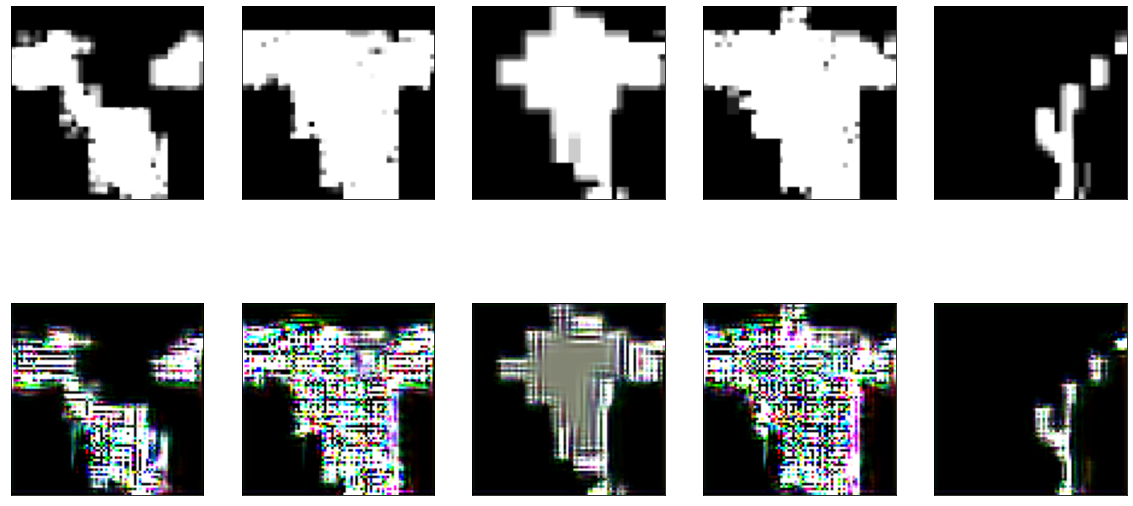

In [25]:
n = 5
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow(val_x_px[i+2])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(predictions[i+2])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()